In [1]:
using LinearAlgebra  #####Son las paqueterias que uso, para instalar una paqueteria basta colocar Pkg.add("Nombre_de_la_paqueteria")
using Plots
using SpecialFunctions: gamma
using Random, Distributions
using StatsBase
using Alert

In [2]:
U(K::Float64,T::Float64)=[T/sqrt(K^2+T^2),0,K/sqrt(K^2+T^2)] #Es la función que da el eje de rotación dependiente de la curvatura y la torsión
ϕ(K::Float64,T::Float64,Δt::Float64)=Δt*sqrt(K^2+T^2) #Es la función que da el angulo de rotación

ψ0(ϕ0,ϕ1,u,w)=2*acos(cos(ϕ1/2)*cos(ϕ0/2)-sin(ϕ1/2)*sin(ϕ0/2)*dot(u,w)) # Es la función para generar el primer angulo  resultado de dos "matrices/cuaternios"

# Son las funciones para generar el primer eje resultado de dos "matrices/cuaternios"
w1x(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[1]+cos(ϕ0/2)*sin(ϕ1/2)*u[1])*csc(ψ0/2) 
w1y(ϕ0,ϕ1,u,w,ψ0)=((u[3]*w[1]-w[3]*u[1])*sin(ϕ1/2)*sin(ϕ0/2))*csc(ψ0/2)
w1z(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[3]+cos(ϕ0/2)*sin(ϕ1/2)*u[3])*csc(ψ0/2)


ψn(ϕ0,ϕ1,u,w)=2*acos(cos(ϕ1/2)*cos(ϕ0/2)-sin(ϕ1/2)*sin(ϕ0/2)*dot(u,w)) # Es la función para generar los otros angulos

# Son las funciones para generar los otros ejes resultado
wnx(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[1]+cos(ϕ0/2)*sin(ϕ1/2)*u[1]-(w[2]*u[3])*sin(ϕ0/2)*sin(ϕ1/2))*csc(ψ0/2)
wny(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[2]+(u[3]*w[1]-w[3]*u[1])*sin(ϕ1/2)*sin(ϕ0/2))*csc(ψ0/2)
wnz(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[3]+cos(ϕ0/2)*sin(ϕ1/2)*u[3]+(w[2]*u[1])*sin(ϕ0/2)*sin(ϕ1/2))*csc(ψ0/2)


wnz (generic function with 1 method)

In [3]:
#Acomodamos el eje y el angulo de rotacion en una matriz de euler-rodriguez

MatRot(ω,Ψ)=[ cos(Ψ)+ω[1]^2*(1-cos(Ψ)) ω[1]*ω[2]*(1-cos(Ψ))-ω[3]*sin(Ψ) ω[1]*ω[3]*(1-cos(Ψ))+ω[2]*sin(Ψ);
                ω[2]*ω[1]*(1-cos(Ψ))+ω[3]*sin(Ψ) cos(Ψ)+ω[2]^2*(1-cos(Ψ)) ω[2]*ω[3]*(1-cos(Ψ))-ω[1]*sin(Ψ);
                    ω[3]*ω[1]*(1-cos(Ψ))-ω[2]*sin(Ψ) ω[3]*ω[2]*(1-cos(Ψ))+ω[1]*sin(Ψ) cos(Ψ)+ω[3]^2*(1-cos(Ψ))]

MatRot (generic function with 1 method)

In [4]:
function serie_tiempo_v(PASO);
    #Generar ejes
    v=Array{Array{Float64,1},1}(undef,PASO)
    K=OUH(k0,t[1:PASO],Δt,DK)         # se obtiene un proceso de Ornstein–Uhlenbeck
    T=OUH(t0,t[1:PASO],Δt,DT,γ,cte1)

    Un=U.(K,T)                                #Se obtiene los ejes infinitesimales
    ϕn=ϕ.(K,T,Δt)                             #Se obtiene los ángulos infinitesimales

    ω=Array{Array{Float64,1},1}(undef,PASO)   #se pondrán aquí los eigenejes en cada paso
    Ψ=Array{Float64,1}(undef,PASO)            #se pondrán aquí los eigenfases en cada paso
    ω[1]=Un[1]                                #se coloca el primer eje
    Ψ[1]=ϕn[1]                                #se coloca la primer fase

    v[1]=ω[1]     #Agregamos el primer eigen eje

    ψ1=ψ0(ϕn[1],ϕn[2],Un[1],Un[2])            #Se construye la segunda fase
    w=[w1x(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),       #Se construye el segundo eje
        w1y(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),
        w1z(ϕn[1],ϕn[2],Un[2],Un[1],ψ1)];
    ω[2]=w                                  #Se coloca el segundo eje
    Ψ[2]=ψ1                                 #Se coloca el segundo angulo

    v[2]=ω[2]   #Agregamos el segundo eigen eje

    for i=3:PASO                            #Agregamos LOS demas eigenejes
        ψ=ψn(ψ1,ϕn[i],Un[i],w)
        w=[wnx(ψ1,ϕn[i],Un[i],w,ψ),wny(ψ1,ϕn[i],Un[i],w,ψ),wnz(ψ1,ϕn[i],Un[i],w,ψ)]
        ω[i]=w
        Ψ[i]=ψ1
        ψ1=ψ
        v[i]=ω[i]
    end    
    return v
end

serie_tiempo_v (generic function with 1 method)

In [392]:
function covariance_S(X::Array{Float64,1},Y::Array{Float64,1})
    n=length(X)
    cov=0
    Xm=mean(X)
    Ym=mean(Y)
    σx=sqrt(var(X))
    σy=sqrt(var(Y))
    for i=1:n
       @inbounds cov=(X[i]-Xm)*(Y[i]-Ym) + cov
    end
    #return (cov/n)/(σx*σy)
    return cov/(n-1)
end

covariance_S (generic function with 1 method)

In [6]:
function OUH(x0::Float64,t::AbstractArray,Δt::Float64,D::Float64,γ::Float64=1.0,cte::Float64=1.0) #Proceso de Ornstein–Uhlenbeck
    x=Vector{Float64}(undef, length(t)) #Definimos un vector lleno de basura para luego sobre escribir en el 
    x[1]=x0    #La primera entrada es la condicion inicial del Proceso de Ornstein–Uhlenbeck
    
    for i=1:length(t)-1                 #Usamos un for para poder hacer el proceso
        x0=x0-γ*Δt*(x0-cte)+(sqrt(2*D*Δt)*randn()) # Es el proceso de Ornstein–Uhlenbeck que depende del paso anterior 
        @inbounds x[1+i]=x0                 #@inbounds ignora si la lista tiene el tamaño adecuado y sobreescribimos en la lista basura
    end
    return x                          # Devolvemos la caminata de Ornstein–Uhlenbeck
end

OUH (generic function with 3 methods)

In [7]:
f(t)=angle(exp(im*sqrt(2)*k0*t))

f (generic function with 1 method)

In [8]:
function serie_tiempo_θ(PASO);     # Nos da la serie de tiempo de las eigenfases
    θ=Array{Float64,1}(undef,PASO)

    K=OUH(k0,t[1:PASO],Δt,DK)
    T=OUH(t0,t[1:PASO],Δt,DT,γ,cte1)

    Un=U.(K,T)
    ϕn=ϕ.(K,T,Δt)

    ω=Array{Array{Float64,1},1}(undef,PASO)
    Ψ=Array{Float64,1}(undef,PASO)
    ω[1]=Un[1]
    Ψ[1]=ϕn[1]
    
    θ[1]=Ψ[1]     #Agregamos la primer eigenfase
    
    ψ1=ψ0(ϕn[1],ϕn[2],Un[1],Un[2])
    w=[w1x(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),
        w1y(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),
        w1z(ϕn[1],ϕn[2],Un[2],Un[1],ψ1)];
    ω[2]=w
    Ψ[2]=ψ1
    
    θ[2]=Ψ[2]     #Agregamos la segunda eigenfase
    
    for i=3:PASO   #Agregamos LOS demas eigenfases
        ψ=ψn(ψ1,ϕn[i],Un[i],w)
        w=[wnx(ψ1,ϕn[i],Un[i],w,ψ),wny(ψ1,ϕn[i],Un[i],w,ψ),wnz(ψ1,ϕn[i],Un[i],w,ψ)]
        ω[i]=w
        Ψ[i]=ψ1
        ψ1=ψ
        θ[i]=Ψ[i]
    end
    
    return θ
end

serie_tiempo_θ (generic function with 1 method)

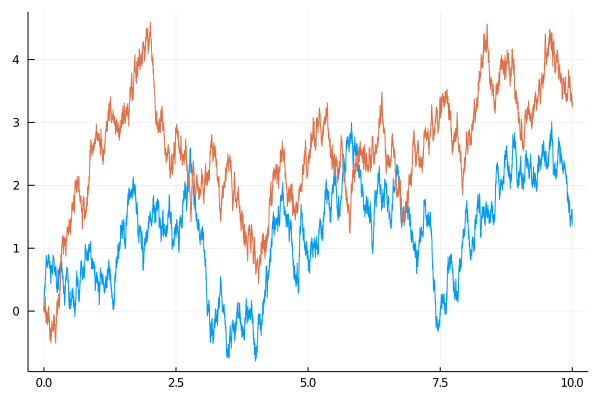

In [10]:
k0=0.01
t0=0.01

γ=1.0

DK=1.0
DT=1.0

N=10.0

Δt=0.001

t=0:Δt:N

cte1=3.0

K=OUH(k0,t,Δt,DK)
T=OUH(t0,t,Δt,DT,γ,cte1)
plot(t,K,legend=false)
plot!(t,T,legend=false)

In [11]:
A=[]
for i=1:500
    push!(A,OUH(t0,t,Δt,DT,γ,cte1))
end

In [12]:
OH=Float64[]
for i=1000:length(t)
    a=covariance_S(transpose(hcat(A...))[:,1000],transpose(hcat(A...))[:,i])
    push!(OH,a)
end

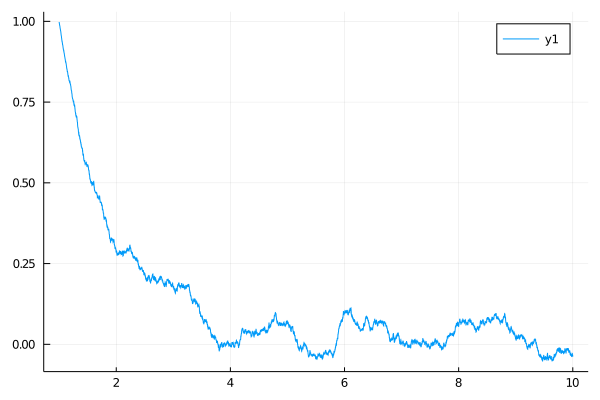

In [13]:
plot(t[1000:length(t)],OH)

## Eigenejes

El resultado analítico bajo la hipotesis de que la curvatura y la torsión son constantes $\kappa=\tau=\kappa_{o}$ de los eigenejes $w(t)$ de la matriz $\mathcal{R}(t)$ es

$$
w(t)=\left(\frac{1}{\sqrt{2}},0,\frac{1}{\sqrt{2}}\right)
$$

pero también puede reescribirse (junto con las eigenfases) como una onda cuadrada

$$
w(t)=
\left\{
	\begin{array}{lll}
		\left(\frac{1}{\sqrt{2}},0,\frac{1}{\sqrt{2}}\right)  & \mbox{si } t \in \left[0,\frac{2\pi}{\sqrt{2}v_{a}\kappa_{o}}\right) \\
        -\left(\frac{1}{\sqrt{2}},0,\frac{1}{\sqrt{2}}\right) & \mbox{si } t \in \left[\frac{2\pi}{\sqrt{2}v_{a}\kappa_{o}},\frac{4\pi}{\sqrt{2}v_{a}\kappa_{o}}\right)\\
        \left(\frac{1}{\sqrt{2}},0,\frac{1}{\sqrt{2}}\right) & \mbox{si } t \in \left[\frac{4\pi}{\sqrt{2}v_{a}\kappa_{o}},\frac{6\pi}{\sqrt{2}v_{a}\kappa_{o}}\right)\\
        \vdots\\
        -\left(\frac{1}{\sqrt{2}},0,\frac{1}{\sqrt{2}}\right) & \mbox{si } t \in \left[\frac{2n\pi}{\sqrt{2}v_{a}\kappa_{o}},\frac{2(n+1)\pi}{\sqrt{2}v_{a}\kappa_{o}}\right)\\
        \left(\frac{1}{\sqrt{2}},0,\frac{1}{\sqrt{2}}\right) & \mbox{si } t \in \left[\frac{2(n+1)\pi}{\sqrt{2}v_{a}\kappa_{o}},\frac{2(n+2)\pi}{\sqrt{2}v_{a}\kappa_{o}}\right)
	\end{array}
\right.
$$

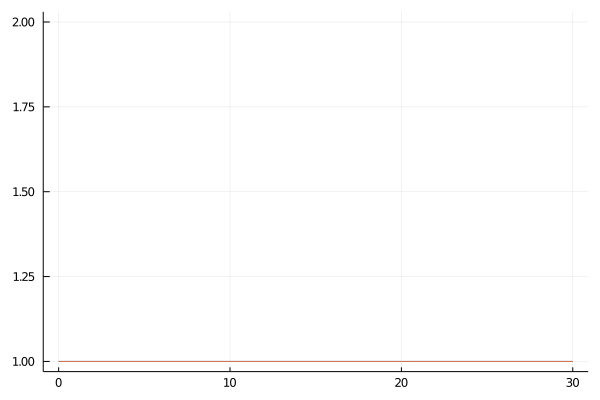

In [358]:
k0=1.0
t0=1.0

γ=1.0

DK=0.0
DT=0.0

N=30.0

Δt=0.001

t=0:Δt:N

cte1=1.0

K=OUH(k0,t,Δt,DK)
T=OUH(t0,t,Δt,DT,γ,cte1)
plot(t,K,legend=false)
plot!(t,T,legend=false)

In [359]:
PASO=length(t)

30001

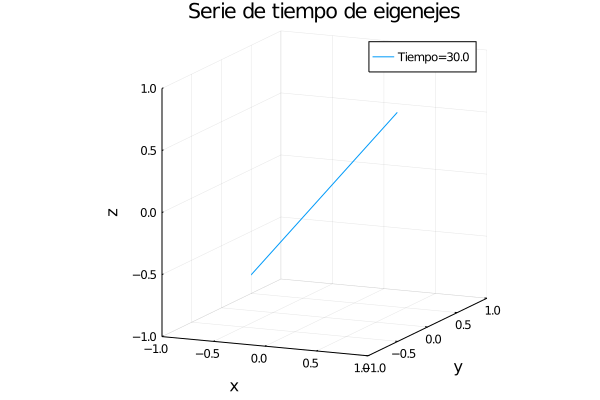

In [360]:
v=serie_tiempo_v(PASO);
plot(transpose(hcat(v...))[:,1],transpose(hcat(v...))[:,2],transpose(hcat(v...))[:,3],markersize=1,xlims=(-1,1),ylims=(-1,1),zlims=(-1,1)
    ,aspect_ratio=:equal,xlabel="x",ylabel="y",zlabel="z",label="Tiempo=$(t[PASO])",markerstrokewidth=0
        ,title="Serie de tiempo de eigenejes")

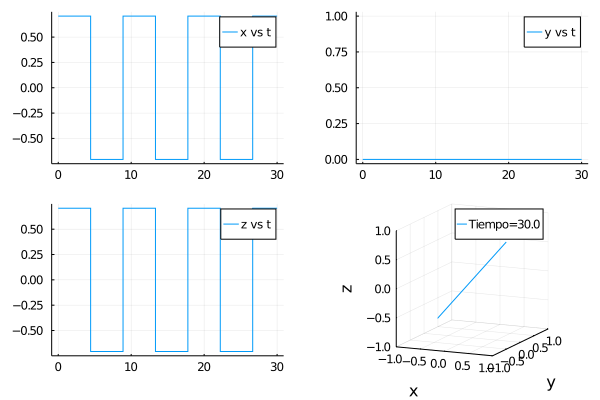

In [361]:

l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
Q1=plot(t[1:PASO],transpose(hcat(v...))[:,1],label="x vs t")
    #plot!(t[1:PASO],(1/sqrt(2))*ones(length(t[1:PASO])),label="")
Q2=plot(t[1:PASO],transpose(hcat(v...))[:,2],label="y vs t")
Q3=plot(t[1:PASO],transpose(hcat(v...))[:,3],label="z vs t")
    #plot!(t[1:PASO],(1/sqrt(2))*ones(length(t[1:PASO])),label="")
Q4=plot(transpose(hcat(v...))[:,1],transpose(hcat(v...))[:,2],transpose(hcat(v...))[:,3],markersize=1,xlims=(-1,1),ylims=(-1,1),zlims=(-1,1)
    ,aspect_ratio=:equal,xlabel="x",ylabel="y",zlabel="z",label="Tiempo=$(t[PASO])",markerstrokewidth=0)
    #plot!([0,1/sqrt(2)],[0,0],[0,1/sqrt(2)],label="")
plot(Q1,Q2,Q3,Q4,layout=l)

In [18]:
savefig("./serie_de_tiempo_eigenejes.png")

In [362]:
t[30001]

30.0

In [363]:
PASO0=1
Step=10
PASOf=length(t)
tiradas=500

500

In [364]:
A=[]   # Va a ser un array donde A[Son las tiradas][Son los eigen ejes #de PASOS]
for i=1:tiradas
    push!(A,serie_tiempo_v(length(t)))
end

In [365]:
m=Float64[]
for j=PASO0:Step:PASOf
    a=Float64[]
    for i=1:tiradas
        push!(a,dot(A[i][PASO0],A[i][j]))
    end
    push!(m,mean(a))
end

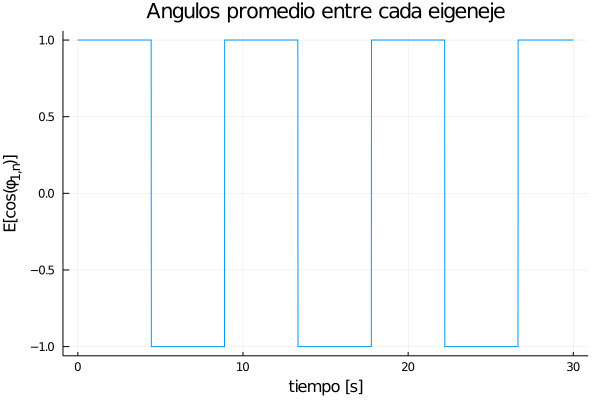

In [366]:
plot(t[PASO0:Step:PASOf],m, title="Angulos promedio entre cada eigeneje",xlabel="tiempo [s]",ylabel="E[cos\\(\\phi_{$(PASO0),n}\\)]",
    label="")#"D_{\\kappa}=D_{\\tau}=$(ηK)")
#plot!(t[PASO0:Step:PASOf],ones(length(t[PASO0:Step:PASOf])),label="")

In [24]:
savefig("./PROMEDIO_EJES_ANGULO_NO_determinista.png")

## Eigenfases

El resultado analítico bajo la hipotesis de que la curvatura y la torsión son constantes $\kappa=\tau=\kappa_{o}$ de lss eigenfases $\psi(t)$ de la matriz $\mathcal{R}(t)$ es

$$
\psi(t)=\sqrt{2}v_{a}\kappa_{o}t
$$

donde $\psi(t)\in[-\pi,\pi]$ lo que hace que la gráfica sea perriodica, con periodicidad $2\pi$, entonces la función realmente es

$$
\psi(t)=
\left\{
	\begin{array}{lll}
		\sqrt{2}v_{a}\kappa_{o}t  & \mbox{si } t \in \left[0,\frac{\pi}{\sqrt{2}v_{a}\kappa_{o}}\right) \\
        \sqrt{2}v_{a}\kappa_{o}t -2\pi & \mbox{si } t \in \left[\frac{\pi}{\sqrt{2}v_{a}\kappa_{o}},\frac{3\pi}{\sqrt{2}v_{a}\kappa_{o}}\right)\\
        \vdots\\
        \sqrt{2}v_{a}\kappa_{o}t -2n\pi & \mbox{si } t \in \left[\frac{(2n-1)\pi}{\sqrt{2}v_{a}\kappa_{o}},\frac{(2n+1)\pi}{\sqrt{2}v_{a}\kappa_{o}}\right)
	\end{array}
\right.
$$


donde $n=1,2,3,\dots$ pero también se puede redefinir con  $\psi(t)\in[0,2\pi]$ como

$$
\psi(t)=
\left\{
	\begin{array}{lll}
		\sqrt{2}v_{a}\kappa_{o}t  & \mbox{si } t \in \left[0,\frac{2\pi}{\sqrt{2}v_{a}\kappa_{o}}\right) \\
        -\sqrt{2}v_{a}\kappa_{o}t +4\pi & \mbox{si } t \in \left[\frac{2\pi}{\sqrt{2}v_{a}\kappa_{o}},\frac{4\pi}{\sqrt{2}v_{a}\kappa_{o}}\right)\\
        \sqrt{2}v_{a}\kappa_{o}t -4\pi & \mbox{si } t \in \left[\frac{4\pi}{\sqrt{2}v_{a}\kappa_{o}},\frac{6\pi}{\sqrt{2}v_{a}\kappa_{o}}\right)\\
        \vdots\\
        -\sqrt{2}v_{a}\kappa_{o}t +4n\pi & \mbox{si } t \in \left[\frac{2n\pi}{\sqrt{2}v_{a}\kappa_{o}},\frac{2(n+1)\pi}{\sqrt{2}v_{a}\kappa_{o}}\right)\\
        \sqrt{2}v_{a}\kappa_{o}t -4n\pi & \mbox{si } t \in \left[\frac{2(n+1)\pi}{\sqrt{2}v_{a}\kappa_{o}},\frac{2(n+2)\pi}{\sqrt{2}v_{a}\kappa_{o}}\right)
	\end{array}
\right.
$$

  0.088677 seconds (656.97 k allocations: 18.494 MiB)


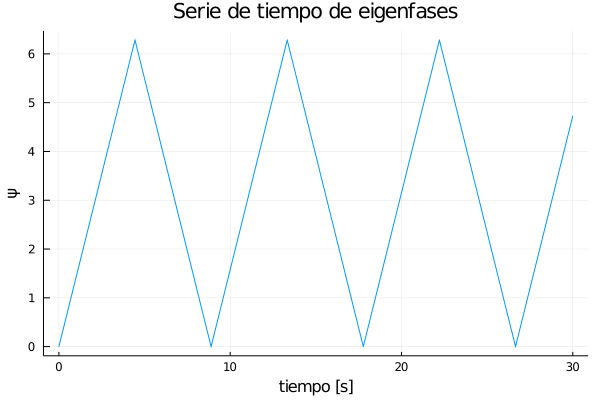

In [377]:
@time a=serie_tiempo_θ(PASO)
plot(t[1:PASO],a,label="",
    title="Serie de tiempo de eigenfases",xlabel="tiempo [s]",ylabel="\\psi")
#plot!(t[1:PASO],f.(t[1:PASO]),label="")

In [51]:
savefig("./serie_de_tiempo_eigenfases.png")

In [393]:

tiradas=500
A=[]
for i=1:tiradas
    push!(A,serie_tiempo_θ(length(t)))
end

In [394]:
PASO0=100
Step=10
PASOf=length(t)


30001

In [395]:
@time covariance_S(transpose(hcat(A...))[:,1000],transpose(hcat(A...))[:,1001])

  0.069210 seconds (20 allocations: 228.906 MiB, 7.56% gc time)


-2.9641567079947837e-31

In [396]:
length(PASO0:Step:PASOf)

2991

In [397]:
@time begin
    OH=Float64[]
    #nor=covariance_S(transpose(hcat(A...))[:,PASO0],transpose(hcat(A...))[:,PASO0])
    for i=PASO0:Step:PASOf
        a=covariance_S(transpose(hcat(A...))[:,PASO0],transpose(hcat(A...))[:,i])#/nor
        push!(OH,a)
    end
end

255.206079 seconds (68.68 k allocations: 668.611 GiB, 20.19% gc time)


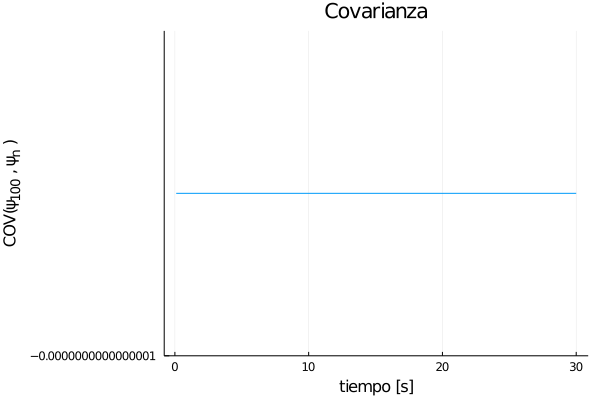

In [398]:
plot(t[PASO0:Step:PASOf],OH,title="Covarianza",xlabel="tiempo [s]",ylabel="COV\\(\\psi_{$(PASO0)} , \\psi_{n} \\)",
    label="")#label="D_{\\kappa}=D_{\\tau}=$(ηK)")

In [58]:
savefig("./COVARIANCE_EIG_Angulos_NO_determinista.png")

In [262]:
k0=0.01
t0=0.01

γ=1.0

DK=0.001
#DT=1.0
DT=DK

N=50.0

Δt=0.001

t=0:Δt:N

cte1=3.0

K=OUH(k0,t,Δt,DK)
T=OUH(t0,t,Δt,DT,γ,cte1);
#plot(t,K,legend=false)
#plot!(t,T,legend=false)

In [263]:
PASO0=1
Step=10
PASOf=length(t)
tiradas=500

500

In [264]:
A=[]   # Va a ser un array donde A[Son las tiradas][Son los eigen ejes #de PASOS]
for i=1:tiradas
    push!(A,serie_tiempo_v(length(t)))
end

In [265]:
m=Float64[]
for j=PASO0:Step:PASOf
    a=Float64[]
    for i=1:tiradas
        push!(a,dot(A[i][PASO0],A[i][j]))
    end
    push!(m,mean(a))
end

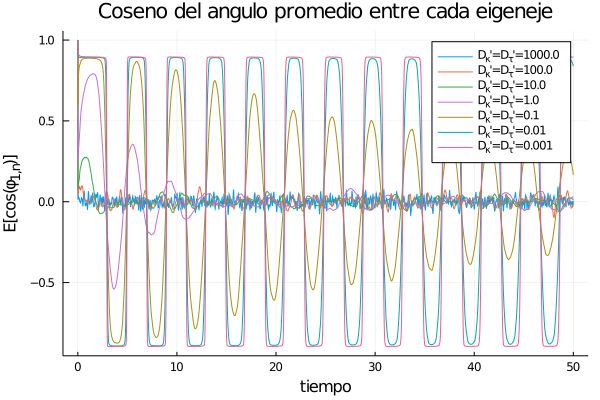

In [266]:
plot!(t[PASO0:Step:PASOf],m, title="Coseno del angulo promedio entre cada eigeneje",xlabel="tiempo",ylabel="E[cos\\(\\phi_{$(PASO0),n}\\)]",
    label="D_{\\kappa}'=D_{\\tau}'=$(DK)")#label="\\gamma=$(γ)")#label="D_{\\kappa}=D_{\\tau}=$(DK)")

In [267]:
savefig("./PROMEDIO_EJES_ANGULO_NO_determinista_var_D.png")

In [399]:
k0=0.01
t0=0.01

γ=1.0

DK=1000.0
#DT=1.0
DT=DK

N=50.0

Δt=0.001

t=0:Δt:N

cte1=3.0

K=OUH(k0,t,Δt,DK)
T=OUH(t0,t,Δt,DT,γ,cte1);
#plot(t,K,legend=false)
#plot!(t,T,legend=false)

In [400]:
tiradas=1000
A=[]
for i=1:tiradas
    push!(A,serie_tiempo_θ(length(t)))
end

In [401]:
PASO0=1000
Step=10
PASOf=length(t)

50001

In [402]:
@time begin
    OH=Float64[]
    #nor=covariance_S(transpose(hcat(A...))[:,PASO0],transpose(hcat(A...))[:,PASO0])
    for i=PASO0:Step:PASOf
        a=covariance_S(transpose(hcat(A...))[:,PASO0],transpose(hcat(A...))[:,i])#/nor
        push!(OH,a)
    end
end

1518.061340 seconds (137.24 k allocations: 3.566 TiB, 20.49% gc time)


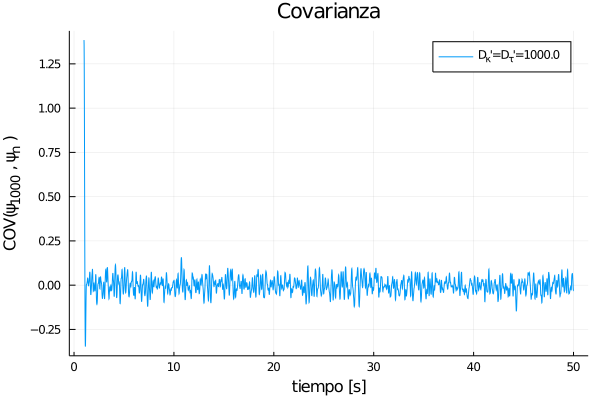

In [403]:
plot!(t[PASO0:Step:PASOf],OH,title="Covarianza",xlabel="tiempo [s]",ylabel="COV\\(\\psi_{$(PASO0)} , \\psi_{n} \\)",
    label="D_{\\kappa}'=D_{\\tau}'=$(DK)")#label="\\gamma=$(γ)")

In [340]:
savefig("./COVARIANCE_EIG_Angulos_NO_determinista_var_D.png")

In [385]:
d=Normal(0,3)

Normal{Float64}(μ=0.0, σ=3.0)

In [390]:
var(rand(d,1000000))

9.003139603480394

```
cov(x::AbstractVector; corrected::Bool=true)
```

Compute the variance of the vector `x`. If `corrected` is `true` (the default) then the sum is scaled with `n-1`, whereas the sum is scaled with `n` if `corrected` is `false` where `n = length(x)`.

---

```
cov(X::AbstractMatrix; dims::Int=1, corrected::Bool=true)
```

Compute the covariance matrix of the matrix `X` along the dimension `dims`. If `corrected` is `true` (the default) then the sum is scaled with `n-1`, whereas the sum is scaled with `n` if `corrected` is `false` where `n = size(X, dims)`.

---

```
cov(x::AbstractVector, y::AbstractVector; corrected::Bool=true)
```

Compute the covariance between the vectors `x` and `y`. If `corrected` is `true` (the default), computes $\frac{1}{n-1}\sum_{i=1}^n (x_i-\bar x) (y_i-\bar y)^*$ where $*$ denotes the complex conjugate and `n = length(x) = length(y)`. If `corrected` is `false`, computes $\frac{1}{n}\sum_{i=1}^n (x_i-\bar x) (y_i-\bar y)^*$.

---

```
cov(X::AbstractVecOrMat, Y::AbstractVecOrMat; dims::Int=1, corrected::Bool=true)
```

Compute the covariance between the vectors or matrices `X` and `Y` along the dimension `dims`. If `corrected` is `true` (the default) then the sum is scaled with `n-1`, whereas the sum is scaled with `n` if `corrected` is `false` where `n = size(X, dims) = size(Y, dims)`.

---

```
cov(X, w::AbstractWeights, vardim=1; mean=nothing,  corrected=false)
```

Compute the weighted covariance matrix. Similar to `var` and `std` the biased covariance matrix (`corrected=false`) is computed by multiplying `scattermat(X, w)` by $\frac{1}{\sum{w}}$ to normalize. However, the unbiased covariance matrix (`corrected=true`) is dependent on the type of weights used:

  * `AnalyticWeights`: $\frac{1}{\sum w - \sum {w^2} / \sum w}$
  * `FrequencyWeights`: $\frac{1}{\sum{w} - 1}$
  * `ProbabilityWeights`: $\frac{n}{(n - 1) \sum w}$ where $n$ equals `count(!iszero, w)`
  * `Weights`: `ArgumentError` (bias correction not supported)

---

```
cov(ce::CovarianceEstimator, x::AbstractVector; mean=nothing)
```

Compute a variance estimate from the observation vector `x` using the  estimator `ce`.

---

```
cov(ce::CovarianceEstimator, x::AbstractVector, y::AbstractVector)
```

Compute the covariance of the vectors `x` and `y` using estimator `ce`.

---

```
cov(ce::CovarianceEstimator, X::AbstractMatrix, [w::AbstractWeights]; mean=nothing, dims::Int=1)
```

Compute the covariance matrix of the matrix `X` along dimension `dims` using estimator `ce`. A weighting vector `w` can be specified. The keyword argument `mean` can be:

  * `nothing` (default) in which case the mean is estimated and subtracted from the data `X`,
  * a precalculated mean in which case it is subtracted from the data `X`. Assuming `size(X)` is `(N,M)`, `mean` can either be:

      * when `dims=1`, an `AbstractMatrix` of size `(1,M)`,
      * when `dims=2`, an `AbstractVector` of length `N` or an `AbstractMatrix` of size `(N,1)`.

---

```
cov(d::MultivariateDistribution)
```

Compute the covariance matrix for distribution `d`. (`cor` is provided based on `cov`).

---

```
cov(d::MatrixDistribution)
```

Compute the covariance matrix for `vec(X)`, where `X` is a random matrix with distribution `d`.

---

```
cov(d::MatrixDistribution, flattened = Val(false))
```

Compute the 4-dimensional array whose `(i, j, k, l)` element is `cov(X[i,j], X[k, l])`.
